# New Plotting Methods

## Summary

A new approach to plotting in Python-Control was introduced in version 0.9.2.

Prior to this, many of the plot functions returned various calculated values as well as generating a plot figure. For example, the `bode_plot` function returned the magnitude, phase and frequency values that were used to make the plot:

```python
plt.figure()
mag, phase, omega = ct.bode_plot(sys, *args, **kwargs)
plt.show()
```

In the latest version, calculations and plotting are carried out in separate steps using an *object-oriented programming* style:

```python
fr = ct.frequency_response(sys, *args, **kwargs)
plt.figure()
fr.plot(kind='bode', *args, **kwargs)
plt.show()
```

In the above, `fr` is an instance of the `FrequencyResponseData` object class. Access to the calculated variables is now achieved as follows:

```python
mag = fr.mag
phase = fr.phase
omega = fr.omega
```

If you are only interested in making the plot, and don't need the calculated data, you can still do this with the original plotting functions:

```python
plt.figure()
ct.bode_plot(sys)
plt.show()
```

However, note that these functions no-longer return the calculated values that they used to.  Instead, they return the Matplotlib figure and/or axes objects.

```python
plt.figure()
fig, axes = ct.bode_plot(sys)
plt.show()
```

This is useful when using the [object-oriented style of making plots in Matplotlib](https://matplotlib.org/matplotblog/posts/pyplot-vs-object-oriented-interface/), which provides some additional functionality and control over plotting.  (Previously, you would use `fig = plt.gcf()` or `axes = plt.gca()` to get access to these).

Also, note that the Matlab-style versions of all these plot functions still exist. These are in the traditional *functional programming* style:

```python
from control.matlab import bode

mag, phase, omega = bode(sys)  # makes a plot and returns the variables
```

The rest of this notebook shows examples of how to use the new and modified functionality.

## Examples - New plotting paradigm

In [1]:
from control import (tf, c2d, rlocus, bode_plot, nyquist_plot, nichols, pole_zero_plot, 
                     evalfr, dcgain, step_response, frequency_response,
                     frequency_response_bode, frequency_response_nyquist, singular_values,
                     singular_values_plot, gangof4_plot, pole, zero, sisotool)
from control.statesp import StateSpace
from control.grid import sgrid, zgrid, nogrid
import numpy as np
import matplotlib.pyplot as plt
import os

### Example systems

In [2]:
# Continuous-time transfer functions
G1 = tf([2, 2], np.convolve([1, 1], [1, 1]))
G2 = tf(130, [1, 8, 30, 56, 65])
G3 = tf(1, np.convolve([-0.5j, 1], [0.5j, 1]));  # pure imag.

# Continuous-time state-space systems
A = np.array([[1, 1], [0, 1]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = 0
Gssc = StateSpace(A, B, C, D)

# Discrete-time systems
Ts = 0.5
G1d = c2d(G1, Ts)
G2d = c2d(G2, Ts)
Gssd = c2d(Gssc, Ts)

### Step responses

/Users/billtubbs/python-control/control/xferfcn.py:1058: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


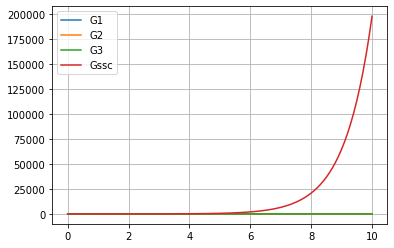

In [3]:
t = np.linspace(0, 10, 101)
fig, ax = plt.subplots()
for label, sys in {'G1': G1, 'G2': G2, 'G3': G3, 'Gssc': Gssc}.items():
    response = step_response(sys, t)
    ax.plot(t, response.y[0, 0, :], label=label)
plt.grid()
plt.legend()
plt.show()

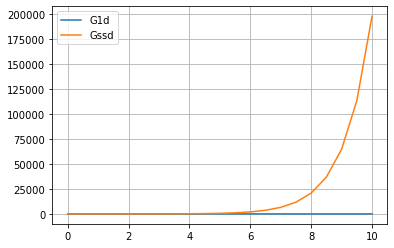

In [4]:
t = Ts*np.arange(0, 21)
fig, ax = plt.subplots()
for label, sys in {'G1d': G1d, 'Gssd': Gssd}.items():
    response = step_response(sys, t)
    ax.plot(t, response.y[0, 0, :], label=label)
plt.grid()
plt.legend()
plt.show()

### Test static gain

In [5]:
sys = G1
assert(dcgain(sys) == 2)
assert(sys(0) == 2)

### Test Frequency Response

In [6]:
sys = G1
w = np.logspace(-1, 1, 3)
mag, phase, wout = frequency_response(sys, w)
assert(np.array_equal(wout, w))
assert(np.array_equal(mag.round(6), [1.990074, 1.414214, 0.199007]))
assert(np.array_equal(np.degrees(phase).round(4), [-5.7106, -45., -84.2894]))

In [7]:
mag, phase, wout = frequency_response_bode(sys)  # same defaults as bode_plot

np.vstack([mag, phase, wout]).T[:10]

array([[ 1.99007438, -0.09966865,  0.1       ],
       [ 1.98998314, -0.1001261 ,  0.10046204],
       [ 1.98989106, -0.10058562,  0.10092622],
       [ 1.98979815, -0.10104721,  0.10139254],
       [ 1.98970438, -0.1015109 ,  0.10186102],
       [ 1.98960976, -0.10197669,  0.10233166],
       [ 1.98951428, -0.10244458,  0.10280447],
       [ 1.98941793, -0.10291459,  0.10327947],
       [ 1.9893207 , -0.10338673,  0.10375667],
       [ 1.98922259, -0.103861  ,  0.10423607]])

### Nyquist Contour and Criterion

In [8]:
sys = G1
assert(sys(0+0j) == 2+0j)
assert(np.isclose(sys(3j), 0.2-0.6j))
assert(np.isclose(evalfr(sys, 3j), 0.2-0.6j))

In [9]:
fr = sys(w*1j)
assert(np.array_equal(fr.round(6), [1.980198-0.198020j, 
                                    1-1j, 0.019802-0.198020j]))

In [10]:
count, contour = frequency_response_nyquist(G2)  # same defaults as nyquist_plot
count, contour.shape

(2, (1000,))

### Bode Plot

In [11]:
sys = G1d

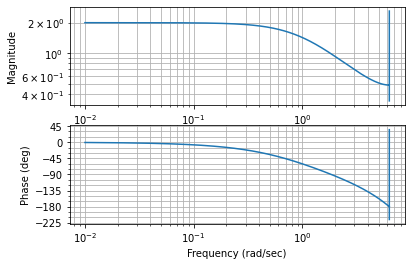

In [12]:
# Quick plot
bode_plot(sys)
plt.show()

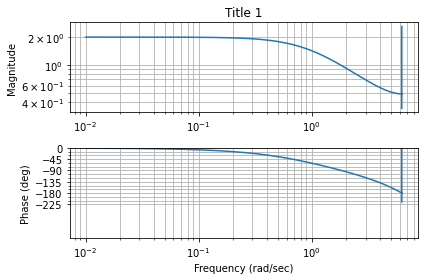

In [13]:
# Plot with axes adjustments
fig, axes = bode_plot(sys)  # TODO: Add kwarg figsize.
axes[0].set_title('Title 1')
axes[1].set_ylim([-360, 0])
plt.tight_layout()
plt.show()

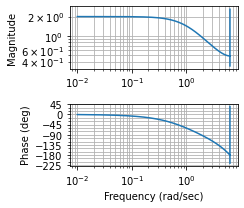

In [14]:
# Use an existing figure
plt.figure(figsize=(3.5, 3))
bode_plot(sys)
plt.tight_layout()
plt.show()

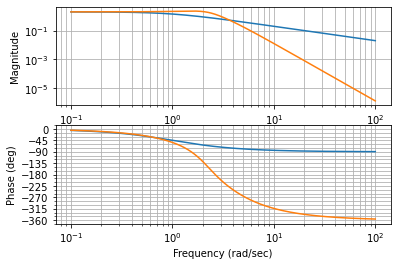

In [15]:
# Bode plot with multiple systems
bode_plot([G1, G2])
plt.show()

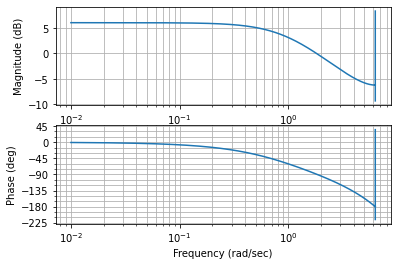

In [16]:
# Test MATLAB wrapper function
from control.matlab import bode

bode(sys)
plt.show()

(array([1.99990206, 1.99990024, 1.99989839, 1.9998965 , 1.99989457,
        1.99989261, 1.99989061, 1.99988857, 1.9998865 , 1.99988439,
        1.99988224, 1.99988004, 1.99987781, 1.99987554, 1.99987322,
        1.99987086, 1.99986846, 1.99986601, 1.99986352, 1.99986098,
        1.99985839, 1.99985576, 1.99985307, 1.99985034, 1.99984756,
        1.99984472, 1.99984183, 1.99983889, 1.99983589, 1.99983283,
        1.99982972, 1.99982656, 1.99982333, 1.99982004, 1.99981669,
        1.99981328, 1.99980981, 1.99980627, 1.99980266, 1.99979899,
        1.99979525, 1.99979144, 1.99978756, 1.99978361, 1.99977958,
        1.99977548, 1.9997713 , 1.99976705, 1.99976271, 1.9997583 ,
        1.9997538 , 1.99974922, 1.99974455, 1.9997398 , 1.99973496,
        1.99973003, 1.999725  , 1.99971989, 1.99971467, 1.99970937,
        1.99970396, 1.99969845, 1.99969284, 1.99968713, 1.9996813 ,
        1.99967537, 1.99966933, 1.99966318, 1.99965692, 1.99965053,
        1.99964403, 1.99963741, 1.99963066, 1.99

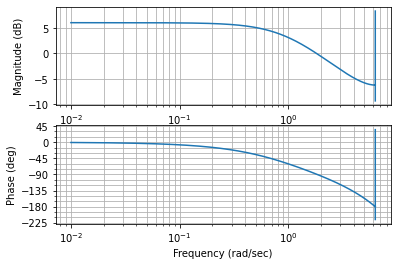

In [17]:
bode(sys)

In [18]:
mag, phase, omega = bode(sys, plot=False)

np.vstack([mag, phase, omega]).T[:10]

array([[ 1.99990206, -0.01270714,  0.01      ],
       [ 1.99990024, -0.01282483,  0.01009262],
       [ 1.99989839, -0.01294361,  0.0101861 ],
       [ 1.9998965 , -0.01306349,  0.01028045],
       [ 1.99989457, -0.01318448,  0.01037567],
       [ 1.99989261, -0.01330659,  0.01047177],
       [ 1.99989061, -0.01342983,  0.01056876],
       [ 1.99988857, -0.01355421,  0.01066665],
       [ 1.9998865 , -0.01367974,  0.01076545],
       [ 1.99988439, -0.01380644,  0.01086516]])

### Nyquist Plot

In [19]:
sys = G1

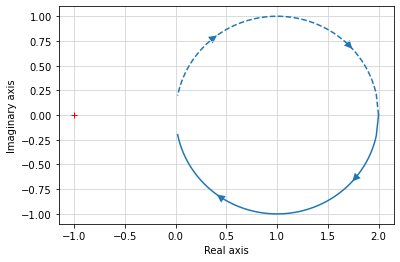

In [20]:
# Quick plot
nyquist_plot(sys)
plt.show()

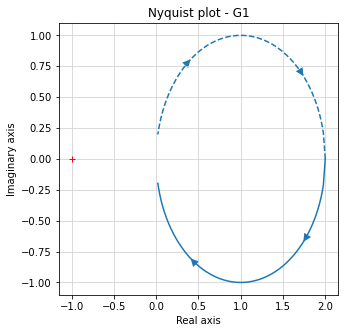

In [21]:
# Plot with axes adjustments
plt.figure(figsize=(5, 5))
ax = nyquist_plot(sys)
ax.set_title('Nyquist plot - G1')
plt.show()

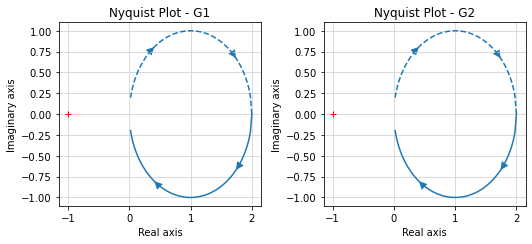

In [22]:
# Add subplots to existing figure
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.5))

ax = axes[0]
nyquist_plot(G1, ax=ax)
ax.set_title('Nyquist Plot - G1')

ax = axes[1]
nyquist_plot(G1, ax=ax)
ax.set_title('Nyquist Plot - G2')

plt.tight_layout()
plt.show()

In [23]:
from control.freqplot import _nyquist_contours_and_encirclements



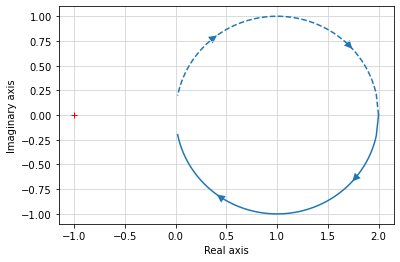

In [24]:
# Test MATLAB wrapper function
from control.matlab import nyquist

nyquist(sys)
plt.show()

In [25]:
re, im, omega = nyquist(sys, plot=False)
np.vstack([re, im, omega]).T[:10]

array([[ 2.        ,  0.        ,  0.        ],
       [ 1.98001644, -0.1989165 ,  0.10046204],
       [ 1.97983322, -0.19981708,  0.10092622],
       [ 1.97964833, -0.20072157,  0.10139254],
       [ 1.97946176, -0.20162999,  0.10186102],
       [ 1.97927351, -0.20254234,  0.10233166],
       [ 1.97908354, -0.20345864,  0.10280447],
       [ 1.97889185, -0.20437891,  0.10327947],
       [ 1.97869843, -0.20530316,  0.10375667],
       [ 1.97850325, -0.2062314 ,  0.10423607]])

### Gang of Four Plot

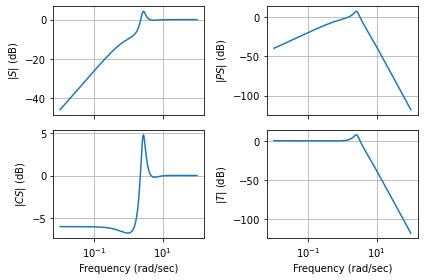

In [26]:
# Quick plot
P = G2
C = tf([0.5, 0.5], [0.5, 0])
gangof4_plot(P, C)
plt.show()

In [27]:
G1

TransferFunction(array([2, 2]), array([1, 2, 1]))

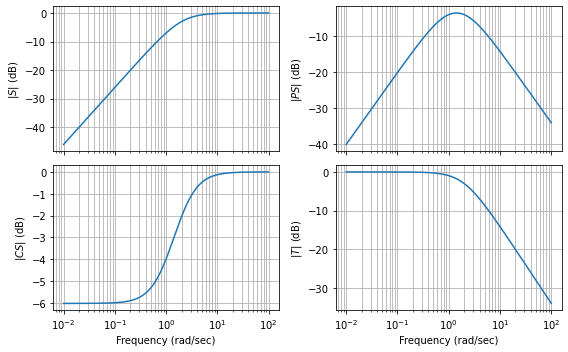

In [28]:
# Using an existing figure
plt.figure(figsize=(8, 5))
P = sys
C = tf([0.5, 0.5], [0.5, 0])
gangof4_plot(P, C)
plt.show()

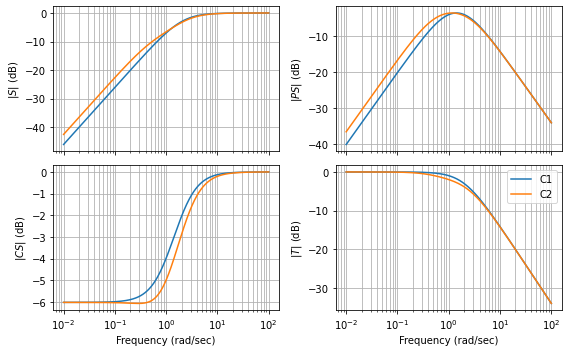

In [29]:
# Two systems on one plot

P = sys
C1 = tf([0.5, 0.5], [0.5, 0])
C2 = tf([0.75, 0.5], [0.75, 0])

plt.figure(figsize=(8, 5))
gangof4_plot(P, C1, label='C1')
gangof4_plot(P, C2, label='C2')

plt.legend()
plt.show()

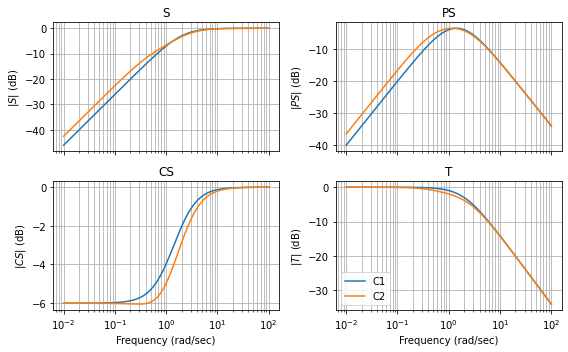

In [30]:
# More control of plotting using axes handles
P = sys
C1 = tf([0.5, 0.5], [0.5, 0])
C2 = tf([0.75, 0.5], [0.75, 0])

plt.figure(figsize=(8, 5))
fig, axes = gangof4_plot(P, C1, label='C1')
fig, axes = gangof4_plot(P, C2, label='C2')

axes[0].set_title('S')
axes[1].set_title('PS')
axes[2].set_title('CS')
axes[3].set_title('T')
axes[3].legend(loc='lower left')

fig.tight_layout()
plt.show()

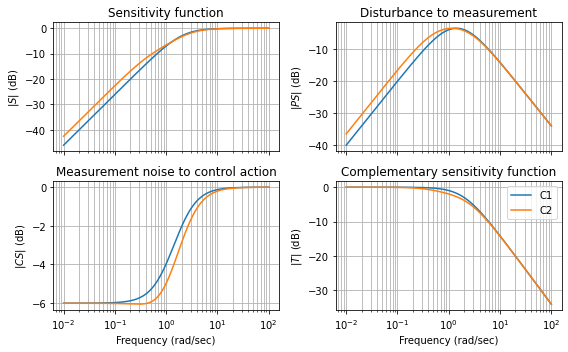

In [31]:
# Full control of plotting
P = sys

controllers = {
    'C1': tf([0.5, 0.5], [0.5, 0]),
    'C2': tf([0.75, 0.5], [0.75, 0])
}

titles = {
    (0, 0): 'Sensitivity function', 
    (0, 1): 'Disturbance to measurement',
    (1, 0): 'Measurement noise to control action',
    (1, 1): 'Complementary sensitivity function'
}

fig, axes = plt.subplots(2, 2, figsize=(8, 5))

for i, (label, C) in enumerate(controllers.items()):
    gangof4_plot(P, C, axes=axes, label=label)
    for pos, title in titles.items():
        axes[pos].set_title(title)
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [32]:
ylabels = [ax.get_ylabel() for ax in axes.flat]
ylabels

['$|S|$ (dB)', '$|PS|$ (dB)', '$|CS|$ (dB)', '$|T|$ (dB)']

### Grids

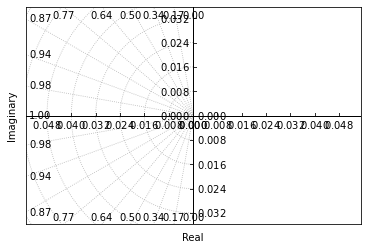

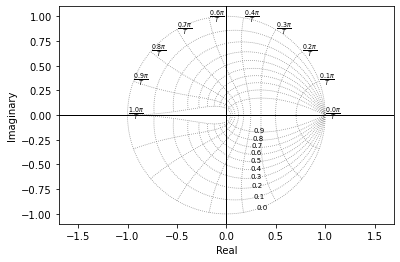

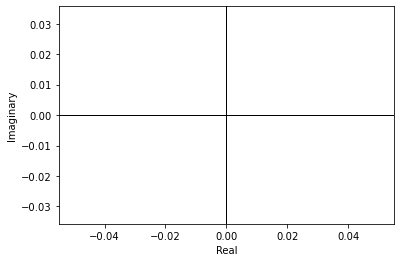

In [33]:
# First test zgrid and sgrid on their own
sgrid()
plt.show()

zgrid()
plt.show()

nogrid()
plt.show()

<AxesHostAxesSubplot:xlabel='Real', ylabel='Imaginary'>

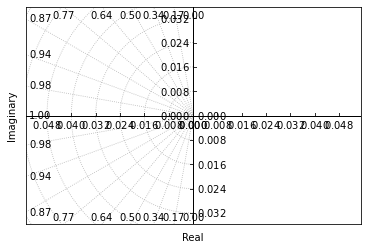

In [34]:
ax = sgrid()
ax

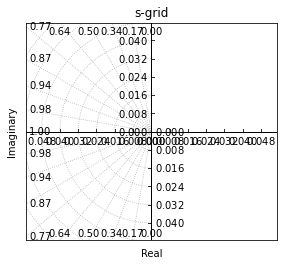

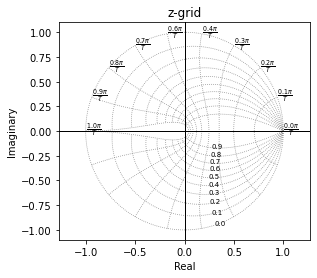

In [35]:
# Detect and use existing figure
plt.figure(figsize=(4.5, 4))
sgrid()
plt.title('s-grid')

plt.figure(figsize=(4.5, 4))
zgrid()
plt.title('z-grid')

plt.show()

Text(0.5, 1.0, 's-plane')

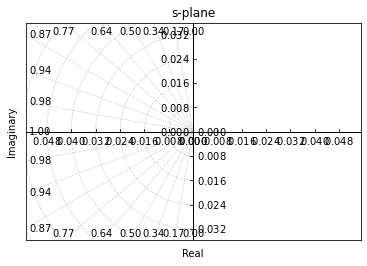

In [36]:
ax = sgrid()
ax.set_title('s-plane')

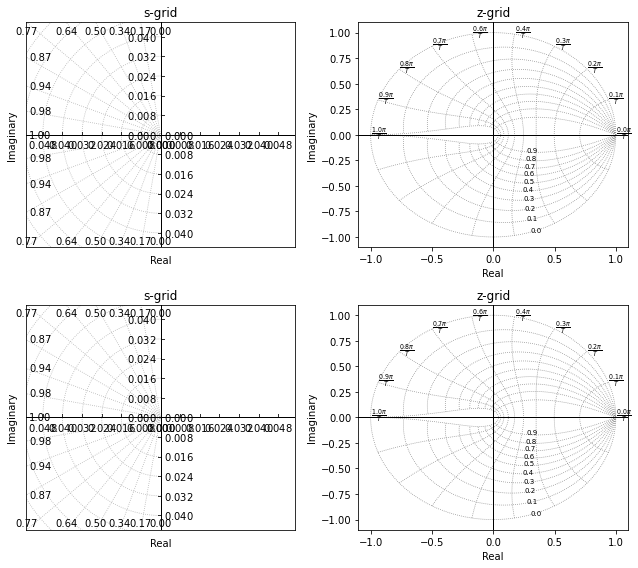

In [37]:
# Adding grids to existing axes
fig, axes = plt.subplots(2, 2, figsize=(9, 8))

ax = axes[0, 0]
ax = sgrid(ax=ax)  # sgrid creates a new ax
ax.set_title('s-grid')

ax = axes[0, 1]
ax = zgrid(ax=ax)
ax.set_title('z-grid')

ax = axes[1, 0]
ax = sgrid(ax=ax)  # sgrid creates a new ax
ax.set_title('s-grid')

ax = axes[1, 1]
ax = zgrid(ax=ax)
ax.set_title('z-grid')

plt.tight_layout()
plt.show()

### Pole-zero plots

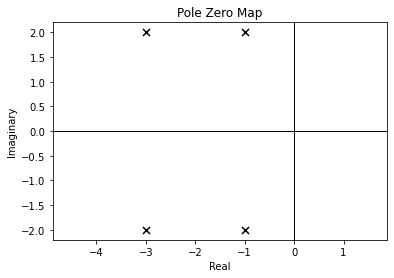

In [38]:
sys = G2
pole_zero_plot(sys)
plt.show()

In [39]:
ps, zs = pole(sys), zero(sys)
ps, zs

(array([-3.+2.j, -3.-2.j, -1.+2.j, -1.-2.j]), array([], dtype=float64))

Text(0.5, 1.0, 'Pole-Zero Map for G2')

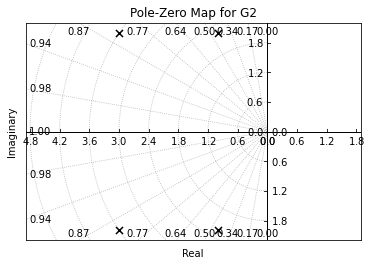

In [40]:
sys = G2
ax = pole_zero_plot(sys, grid=True)
ax.set_title('Pole-Zero Map for G2')

<AxesSubplot:title={'center':'Pole Zero Map'}, xlabel='Real', ylabel='Imaginary'>

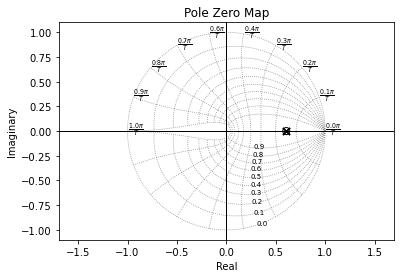

In [41]:
pole_zero_plot(G1d, grid=True)

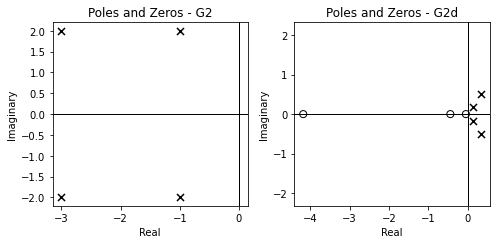

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

ax = axes[0]
ax = pole_zero_plot(G2, ax=ax)
ax.set_title('Poles and Zeros - G2')

ax = axes[1]
ax = pole_zero_plot(G2d, ax=ax)
ax.set_title('Poles and Zeros - G2d')

plt.tight_layout()
plt.show()

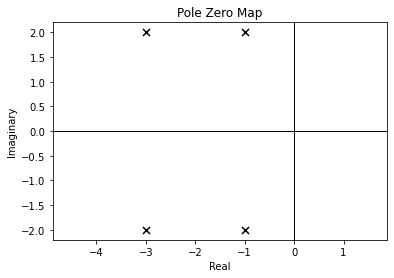

In [43]:
# Test MATLAB wrapper function
from control.matlab import pzmap

ps, zs = pzmap(G2)
plt.show()

In [44]:
ps, zs = pzmap(G2, plot=False)
ps, zs

(array([-3.+2.j, -3.-2.j, -1.+2.j, -1.-2.j]), array([], dtype=float64))

### SISO Tool

In [45]:
help(sisotool)

Help on function sisotool in module control.sisotool:

sisotool(sys, kvect=None, xlim_rlocus=None, ylim_rlocus=None, plotstr_rlocus='C0', rlocus_grid=False, omega=None, dB=None, Hz=None, deg=None, omega_limits=None, omega_num=None, margins_bode=True, tvect=None)
    Sisotool style collection of plots inspired by MATLAB's sisotool.
    The left two plots contain the bode magnitude and phase diagrams.
    The top right plot is a clickable root locus plot, clicking on the
    root locus will change the gain of the system. The bottom left plot
    shows a closed loop time response.
    
    Parameters
    ----------
    sys : LTI object
        Linear input/output systems. If sys is SISO, use the same
        system for the root locus and step response. If it is desired to
        see a different step response than feedback(K*loop,1), sys can be
        provided as a two-input, two-output system (e.g. by using
        :func:`bdgalg.connect' or :func:`iosys.interconnect`). Sisotool
        

### Singular value plot

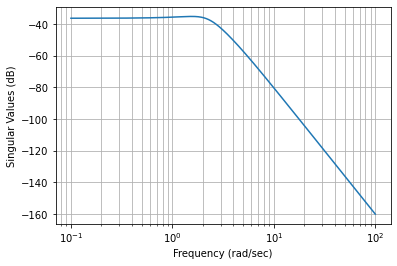

In [58]:
sys = G2
plt.figure()
singular_values_plot(sys)
plt.show()

In [61]:
sigma, omega = singular_values(sys)
sigma.shape, omega.shape

((1, 1000), (1000,))

### Root-locus plot

In [47]:
# Define test systems
s = tf('s')
G1 = 2*(s+1)/(s*(s-2))
G2 = tf(1, [1, 8, 30, 56, 65])
Gz1 = c2d(G1, 0.2)
Gz2 = c2d(G2, 0.2)

In [62]:
plt.figure()
root_locus_plot(G1)
plt.show()

NameError: name 'root_locus_plot' is not defined

<Figure size 432x288 with 0 Axes>

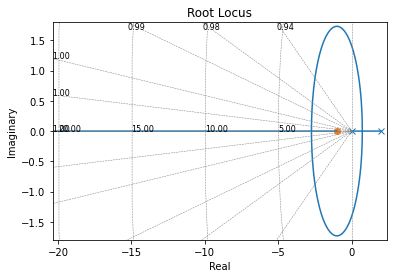

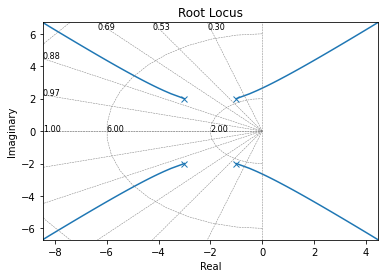

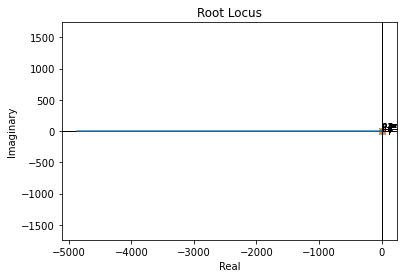

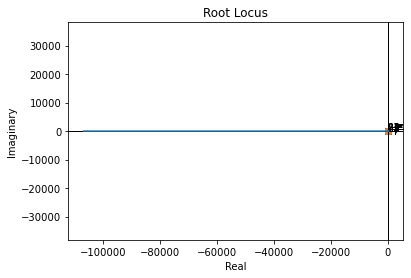

In [49]:
# Single plots
plt.figure()
rlocus(G1, title='Root Locus - G1')

plt.figure()
rlocus(G2, title='Root Locus - G2')

plt.figure()
rlocus(Gz1, title='Root Locus - Gz1')

plt.figure()
rlocus(Gz2, title='Root Locus - Gz2')

plt.show()

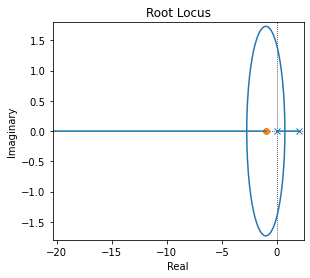

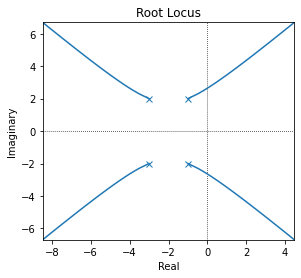

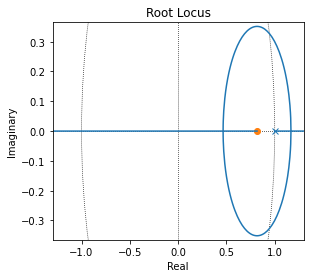

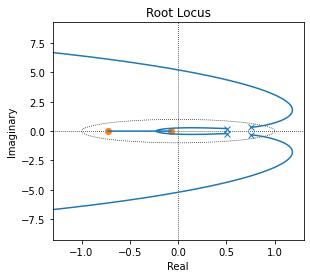

In [50]:
# Single default plots - without grid
plt.figure(figsize=(4.5, 4))
rlocus(G1, grid=False, title='Root Locus - G1')

plt.figure(figsize=(4.5, 4))
rlocus(G2, grid=False, title='Root Locus - G2')

plt.figure(figsize=(4.5, 4))
rlocus(Gz1, grid=False, title='Root Locus - Gz1')

plt.figure(figsize=(4.5, 4))
rlocus(Gz2, grid=False, title='Root Locus - Gz2')
plt.show()

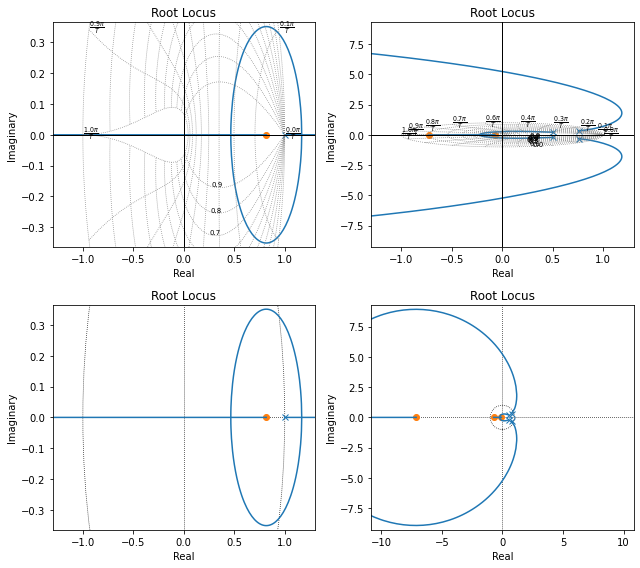

In [51]:
# Subplots - discrete time
fig, axes = plt.subplots(2, 2, figsize=(9,8))
rlocus(Gz1, ax=axes[0, 0], title='Gz1')
rlocus(Gz2, ax=axes[0, 1], title='Gz1')
rlocus(Gz1, ax=axes[1, 0], grid=False, title='Gz1 - no grid')
rlocus(Gz2, ax=axes[1, 1], grid=False, title='Gz1 - no grid')
plt.tight_layout()
plt.show()

NameError: name 'root_locus_plot' is not defined

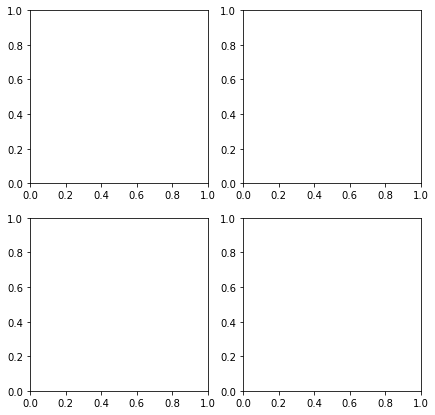

In [52]:
# Subplots - continuous time, done differently due to sgrid
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
root_locus_plot(G1, ax=axes[0], title='G1')
root_locus_plot(G2, ax=axes[1], title='G2')
root_locus_plot(G1, ax=axes[2], grid=False, title='G1 - no grid')
root_locus_plot(G2, ax=axes[3], grid=False, title='G2 - no grid')
plt.tight_layout()
plt.show()

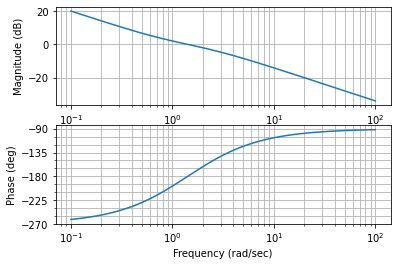

In [ ]:
x = bode(G1)

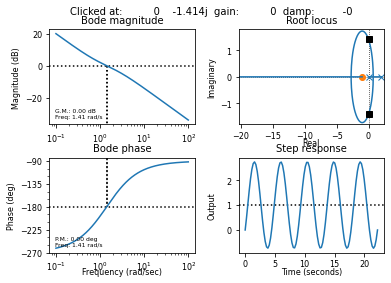

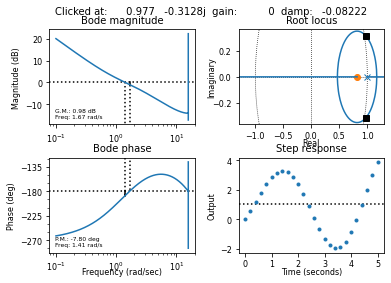

In [ ]:
# Check sisotool works (includes rlocus plot)
sisotool(G1)
plt.show()

sisotool(Gz1)
plt.show()

<font color='red'>**Delete all below - for development/testing only**</font>

### How to make subplots with different projections

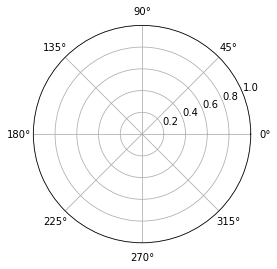

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))

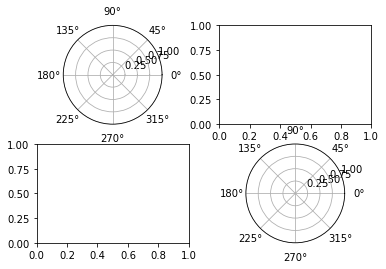

In [ ]:
fig = plt.figure()
fig.add_subplot(2, 2, 1, projection='polar')
fig.add_subplot(2, 2, 2)
fig.add_subplot(2, 2, 3)
fig.add_subplot(2, 2, 4, projection='polar')
plt.show()